<a href="https://colab.research.google.com/github/Alonso94/GSoC-DGP/blob/master/test_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from mpl_toolkits.mplot3d import Axes3D
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk

%pylab inline
plt.rcParams['axes.facecolor']='white'
%config InlineBackend.figure_format="png"

Populating the interactive namespace from numpy and matplotlib


In [0]:
sess=tf.InteractiveSession()

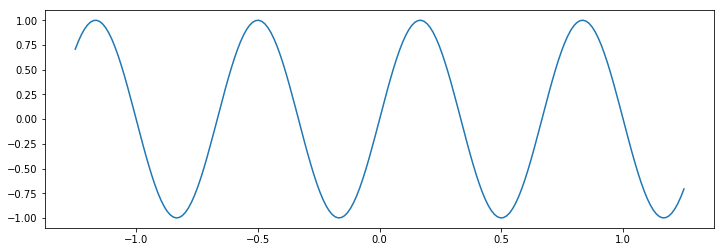

In [3]:
# test matplot
plt.figure(figsize=(12,4))
x=np.linspace(-1.25,1.25,200)
y= np.sin(3*np.pi*x)
plt.plot(x,y)
plt.show()

In [0]:
class layer:
  def __init__(self, X, Y,
               a_initial_val=1, ls_initial_val=1,obs_nv_initial_val=1, 
               learning_rate=0.1):
    
    self.X=X;
    self.Y=Y;
    # generate training variable of the layer
    # a - amplitude
    # ls - length scale
    # obs_nv - observation noise variance
    # these variables will be optimized during the training

    # finfo : Machine limits for floating point types
    # tiny : The smallest positive usable numbe
    # softplus: a smooth approximation of a rectifier 
    # rectifier(x) = max(0,x)
    # softplus(x) = log(1+exp(x))
    tiny=np.finfo(np.float64).tiny

    a_variable=tf.Variable(initial_value=a_initial_val,name="amplitude",dtype=np.float64)
    self.a=(tiny + tf.nn.softplus(a_variable))

    ls_variable=tf.Variable(initial_value=ls_initial_val,name="length_scale",dtype=np.float64)
    self.ls=(tiny + tf.nn.softplus(ls_variable))

    obs_nv_variable=tf.Variable(initial_value=obs_nv_initial_val,name="observation_noise_variance",dtype=np.float64)
    self.obs_nv=(tiny + tf.nn.softplus(obs_nv_variable))
    
    # use Exponentiated quadratic kernel
    # or could be called squared exponential, Gaussian, or radial basis function
    # k(x, y) = amplitude**2 * exp(-||x - y||**2 / (2 * length_scale**2))
    self.kernel = tfk.ExponentiatedQuadratic( self.a, self.ls )

    # creat GP prior distribtion
    self.gp=tfd.GaussianProcess(kernel=self.kernel, index_points=self.X, observation_noise_variance=self.obs_nv)

    # log likelihood for obseration, the goal is to maximize it
    self.log_likelihood=self.gp.log_prob(self.Y)

    # define optimizer
    self.optimizer=tf.train.AdamOptimizer(learning_rate=0.1)
    self.train_op=self.optimizer.minimize(-self.log_likelihood)
    
    sess.run(tf.global_variables_initializer())
    
    
  def update_XY(self, X, Y):
    self.X=X;
    self.Y=Y;
    
  def train(self,num_iters=1000):
    # optimize the model parameters
    self.likelis=[]

    for i in range(num_iters):
      _,likeli=sess.run([self.train_op,self.log_likelihood])
      self.likelis.append(likeli)

    # the results of training
    [a_,ls_,obs_nv_]=sess.run([self.a,self.ls,self.obs_nv])
    print("Training results:")
    print("amplitude = %.2f" % a_)
    print("lengthscale = %.2f" % ls_)
    print("observation_noise_variance = %.2f" % obs_nv_)
    
  def plot_loss(self):
    # plot the loss function (likelihood)
    plt.figure(figsize=(12, 4))
    plt.plot(self.likelis)
    plt.xlabel("Training iteration")
    plt.ylabel("Log marginal likelihood")
    plt.show()
    
  def sample(self, new_X, num_samples=50, predictive_noise_variance=0):
    # sample from the posterior after training
    self.new_X=new_X[...,np.newaxis]

    # use Gaussian process regression model
    # with the same trained kernel
    self.gpr=tfd.GaussianProcessRegressionModel(kernel=self.kernel, index_points=self.new_X,
                                           observation_index_points=self.X, observations=self.Y,
                                           observation_noise_variance=self.obs_nv,predictive_noise_variance=predictive_noise_variance)

    # draw samples
    self.num_samples=num_samples
    samples=self.gpr.sample(num_samples)
    self.samples_=sess.run(samples)
    
  def plot_results(self, real_Y):
    # plot all
    plt.figure(figsize=(12, 4))

    # the real function
    plt.plot(self.new_X, real_Y, label='True fn')

    # the observation
    plt.scatter(self.X[:, 0], self.Y, label='Observations')

    # the samples
    for i in range(self.num_samples):
      plt.plot(self.new_X, self.samples_[i, :], c='r', alpha=.1, label='Posterior Sample' if i == 0 else None)

    leg = plt.legend(loc='upper right')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.xlabel(r"Index points ($\mathbb{R}^1$)")
    plt.ylabel("Observation space")
    plt.show()

In [0]:
num_training_points=100
# generate x and y
X=np.random.uniform(-1,1,(num_training_points,1)).astype(np.float64)
# a[...,0] selects the first elements in the last dimension of a multidimensional array
real_Y= np.sin(3*np.pi*X[...,0])

observation_noise_variance=0.1
Y=real_Y+np.random.normal(loc=0,scale=np.sqrt(observation_noise_variance),size=num_training_points)

W0710 06:56:37.926843 139721928206208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training results:
amplitude = 0.78
lengthscale = 0.14
observation_noise_variance = 0.14


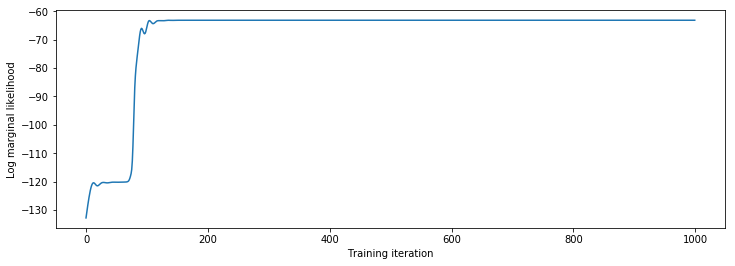

In [6]:
layer1=layer(X,Y)
layer1.train()
layer1.plot_loss()

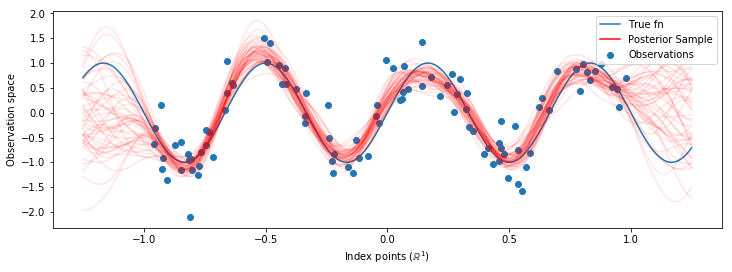

In [7]:
new_X=np.linspace(-1.25,1.25,200,dtype=np.float64)
real_Y= np.sin(3*np.pi*new_X)

layer1.sample(new_X)
layer1.plot_results(real_Y)